In [54]:
from scipy.io.matlab import loadmat 
import numpy as np
import matplotlib.pyplot as plt

import torch as torch
import torch.nn as nn
device = torch.device("cuda:0")

### Helper functions

In [91]:
def count_parameters(model):
    '''
    Count total number of parameters in model
    '''
    n_param = 0
    for parameter in model.parameters():
        numpy = parameter.detach().numpy()
        n_param += np.product(numpy.shape)
    return n_param

In [92]:
def conv_output_width(input_width,kernel_width,stride,repeat = 1):
    '''
    calculate output-width of (stacked) conv-layers
    '''
    out_width = input_width
    for _ in range(repeat):
        out_width = int((out_width - kernel_width - 0)/stride + 1)
    return out_width

# Data import

In [93]:
input_100pM_p1 = loadmat('Data/Stimulation_100pM_2013.mat')
input_100pM_p2 = loadmat('Data/Stimulation_100pM_2014.mat')
combined_data = np.concatenate((input_100pM_p1['DataOI_r'].T,input_100pM_p2['DataOI_r'].T))
print(combined_data.shape)

(730, 289)


# GAN Models

In [197]:
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.convT1 = nn.ConvTranspose1d(2,128,6,2,bias=True)
        self.convT2 = nn.ConvTranspose1d(128,64,6,2,bias=True)
        self.convT3 = nn.ConvTranspose1d(64,32,6,2,bias=False)
        self.convT4 = nn.ConvTranspose1d(32,16,6,2,bias=False)
        
        self.convT5 = nn.ConvTranspose1d(16,8,6,1,bias=True)
        self.convT6 = nn.ConvTranspose1d(8,4,6,1,bias=False)
        self.convT7 = nn.ConvTranspose1d(4,2,6,1,bias=True)
        self.convT8 = nn.ConvTranspose1d(2,1,7,1,bias=False)
        
        self.relu = nn.LeakyReLU(0.3) # nn.ReLU()
        
    def forward(self,x):
        x = self.convT1(x)
        x = self.convT2(x)
        x = self.convT3(x)
        x = self.convT4(x)
        
        x = self.convT5(x)
        x = self.convT6(x)
        x = self.convT7(x)
        x = self.relu(x)
        x = self.convT8(x)
        x = self.relu(x)
        return x

In [198]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        self.conv1 = nn.Conv1d(1,2,6,2)        
        self.conv2 = nn.Conv1d(2,4,6,2)        
        self.conv3 = nn.Conv1d(4,8,6,2)        
        self.conv4 = nn.Conv1d(8,16,6,2)        
        
        out_width = conv_output_width(289,6,2,4)*16
        self.flat = nn.Flatten()
        self.lin1 = nn.Linear(out_width,out_width//2)
        self.lin2 = nn.Linear(out_width//2,out_width//8)
        self.lin3 = nn.Linear(out_width//8,out_width//16)
        self.lin4 = nn.Linear(out_width//16,out_width//32)
        self.lin5 = nn.Linear(out_width//32,1)
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        
        x = self.flat(x)
        x = self.relu(x)
        x = self.lin1(x)
        x = self.relu(x)
        x = self.lin2(x)
        x = self.relu(x)
        x = self.lin3(x)
        x = self.relu(x)
        x = self.lin4(x)
        x = self.relu(x)
        x = self.lin5(x)
        x = self.sigmoid(x)
        return x

In [223]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.1)

In [224]:
torch.manual_seed(66)

gen = Generator()
gen.apply(weights_init)
dis = Discriminator()
print(count_parameters(gen))
print(count_parameters(dis))

67272
29933


### Prove of concept: Does the scale of the noise match?

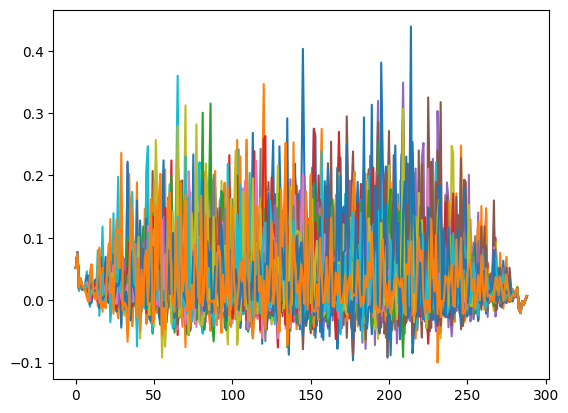

In [225]:
gen_noise = torch.randn(32, 2,13)
fakes = gen(gen_noise)
data = fakes.detach().numpy().reshape([-1,289]).T
plt.plot(data)
plt.show()

# GAN Training

In [226]:
epochs = 100
batch_size = 32
learning_reate_gen = 3e-4
learning_rate_dis = 3e-4
beta1 = 0.5
beta2 = 0.999

real_label = 1
fake_label = 0

dataloader = torch.utils.data.DataLoader(combined_data.reshape([-1,1,289]), batch_size=batch_size)
n_data = combined_data.shape[0]
torch.manual_seed(33)

const_noise = torch.randn(samp.shape[0], 2,13)

criterion = nn.BCELoss()
optimizer_dis = torch.optim.Adam(dis.parameters(), lr=learning_rate_dis, betas=(beta1, beta2))
optimizer_gen = torch.optim.Adam(gen.parameters(), lr=learning_reate_gen, betas=(beta1, beta2))

scores_dis_real = []
scores_dis_fake = []
scores_gen_fake = []

losses_dis_real = []
losses_dis_fake = []
losses_gen_fake = []

inter_images = []

for e in range(epochs):

    running_scores_dis_real = 0.0
    running_scores_dis_fake = 0.0
    running_scores_gen_fake = 0.0
    
    running_loss_dis_real = 0.0
    running_loss_dis_fake = 0.0
    running_loss_gen_fake = 0.0

    for samp in dataloader:
        real_labels = torch.full((samp.shape[0],1), real_label, dtype=torch.float)
        fake_labels = torch.full((samp.shape[0],1), fake_label, dtype=torch.float)

        # Train discriminator
        dis.zero_grad()
        # ~ on real data
        real_scores = dis.forward(samp.float())
        err_diss_real = criterion(real_scores, real_labels)
        err_diss_real.backward()
        running_scores_dis_real += real_scores.sum().item()
        running_loss_dis_real += err_diss_real.sum().item()
        
        # ~ on fake data
        gen_noise = torch.randn(samp.shape[0], 2,13)
        fakes = gen(gen_noise)
        fake_scores = dis(fakes.detach())
        err_diss_fake = criterion(fake_scores, fake_labels)
        err_diss_fake.backward()
        running_scores_dis_fake += fake_scores.sum().item()
        running_loss_dis_fake += err_diss_fake.sum().item()
        optimizer_dis.step()
        

        # Train generator
        gen.zero_grad()
        fake_dis_scores = dis(fakes)
        err_gen_fake = criterion(fake_dis_scores, real_labels)
        err_gen_fake.backward()
        running_scores_gen_fake += fake_dis_scores.sum().item()
        running_loss_gen_fake += err_gen_fake.sum().item()
        optimizer_gen.step()

    scores_dis_real.append(running_scores_dis_real/n_data)
    scores_dis_fake.append(running_scores_dis_fake/n_data)
    scores_gen_fake.append(running_scores_gen_fake/n_data)
    losses_dis_real.append(running_loss_dis_real/n_data)
    losses_dis_fake.append(running_loss_dis_fake/n_data)
    losses_gen_fake.append(running_loss_gen_fake/n_data)
    
    if e%5 == 0:
        validate_fakes = gen(const_noise)
        inter_images.append(validate_fakes)         
        print(f'Epoch {e+1:3d}: Scores: Dis real:{scores_dis_real[-1]*100:.1f}%,  Dis fake:{scores_dis_fake[-1]*100:.1f}%,  Gen fake:{scores_gen_fake[-1]*100:.1f}%')
        print(f'           Losses: Dis real:{losses_dis_real[-1]:.3f},  Dis fake:{losses_dis_fake[-1]:.3f},  Gen fake:{losses_gen_fake[-1]:.3f}')

Epoch   1: Scores: Dis real:43.9%,  Dis fake:43.8%,  Gen fake:43.9%
           Losses: Dis real:0.026,  Dis fake:0.018,  Gen fake:0.026
Epoch   6: Scores: Dis real:50.4%,  Dis fake:48.7%,  Gen fake:48.6%
           Losses: Dis real:0.022,  Dis fake:0.021,  Gen fake:0.023
Epoch  11: Scores: Dis real:50.1%,  Dis fake:47.5%,  Gen fake:47.2%
           Losses: Dis real:0.022,  Dis fake:0.020,  Gen fake:0.024
Epoch  16: Scores: Dis real:47.6%,  Dis fake:48.1%,  Gen fake:47.7%
           Losses: Dis real:0.023,  Dis fake:0.021,  Gen fake:0.023
Epoch  21: Scores: Dis real:48.9%,  Dis fake:49.4%,  Gen fake:49.3%
           Losses: Dis real:0.023,  Dis fake:0.021,  Gen fake:0.022
Epoch  26: Scores: Dis real:50.8%,  Dis fake:49.8%,  Gen fake:49.7%
           Losses: Dis real:0.021,  Dis fake:0.022,  Gen fake:0.022
Epoch  31: Scores: Dis real:50.2%,  Dis fake:50.1%,  Gen fake:49.9%
           Losses: Dis real:0.022,  Dis fake:0.022,  Gen fake:0.022
Epoch  36: Scores: Dis real:50.5%,  Dis fake:50.

# Verify the training: Scores stays stably ~50%

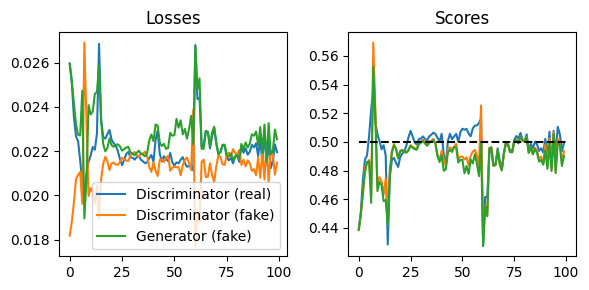

In [227]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.plot(losses_dis_real,label='Discriminator (real)')
plt.plot(losses_dis_fake,label='Discriminator (fake)')
plt.plot(losses_gen_fake,label='Generator (fake)')
plt.legend()
plt.title('Losses')

plt.subplot(1,2,2)
plt.plot(scores_dis_real)
plt.plot(scores_dis_fake)
plt.plot(scores_gen_fake)
plt.plot([0,len(scores_dis_fake)],[0.5,0.5],'k--')
plt.title('Scores')
plt.tight_layout()

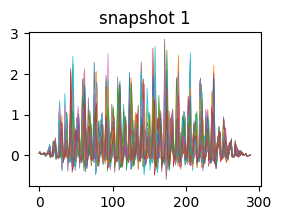

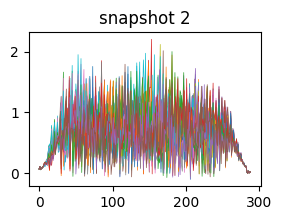

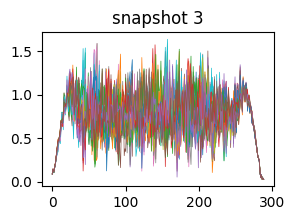

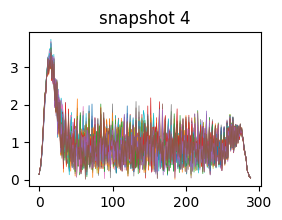

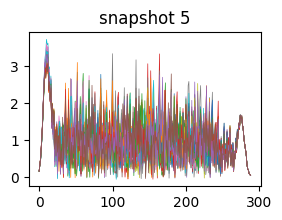

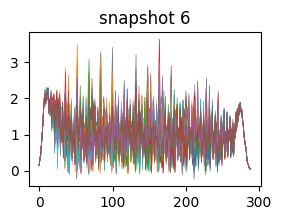

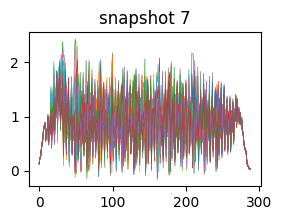

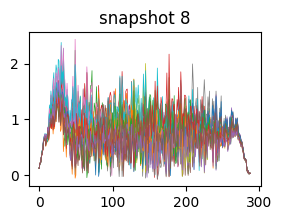

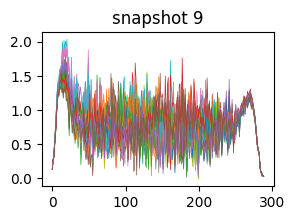

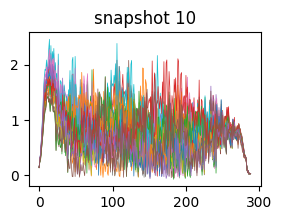

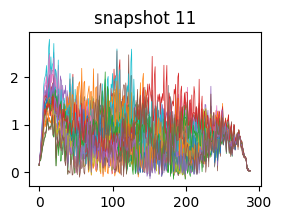

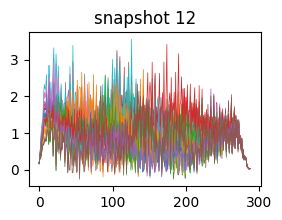

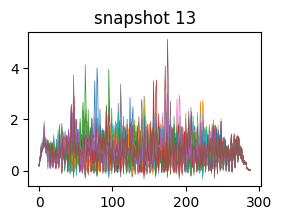

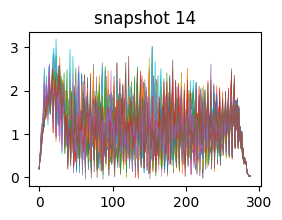

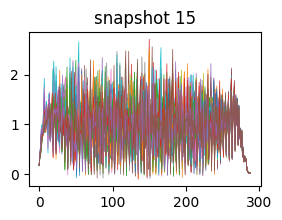

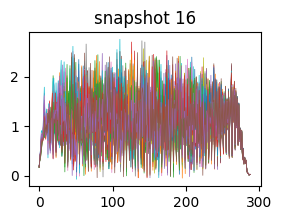

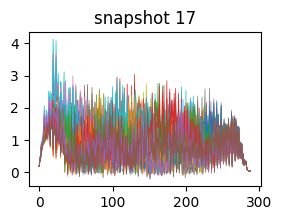

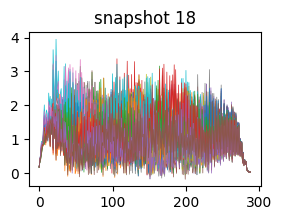

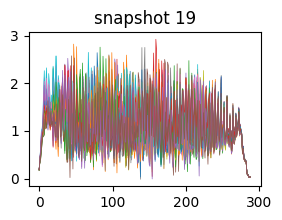

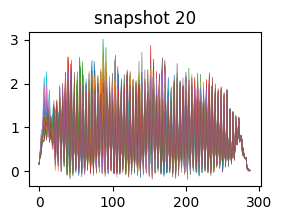

In [241]:
for k,snap_shot in enumerate(inter_images):
    data = snap_shot.detach().numpy().reshape([-1,289]).T
    plt.figure(figsize=(3,2))
    plt.plot(data,linewidth=0.5)
    plt.title('snapshot %d'%(k+1))
    plt.show()

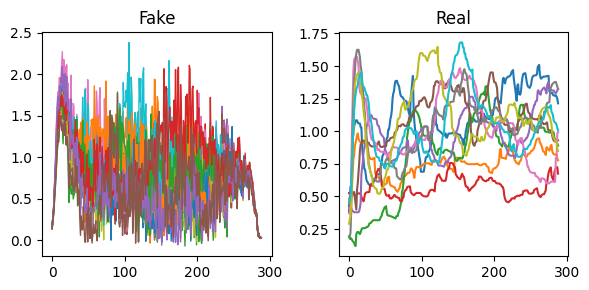

In [248]:
#torch.manual_seed(12)
#gen_noise = torch.randn(samp.shape[0], 2,13)
#fakes = gen(gen_noise)
data = inter_images[9].detach().numpy().reshape([-1,289]).T


plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.plot(data[:,10:30],linewidth=1)
plt.title('Fake')

plt.subplot(1,2,2)
plt.plot(combined_data[:10].T)
plt.title('Real')
plt.tight_layout()